In [1]:
import shutil
import tkinter as tk
import requests
import datetime
import findspark
import pandas as pd
import numpy as np
%pylab inline
findspark.init('C:/Spark/spark-2.2.0-bin-hadoop2.7/spark-2.2.0-bin-hadoop2.7')
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.mllib.regression import LabeledPoint 
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils
sc = SparkContext()
sqlContext = SQLContext(sc)
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Populating the interactive namespace from numpy and matplotlib


In [14]:
def price_historical(symbol, comparison_symbol, all_data=True, limit=1, aggregate=1, exchange=''):
    print('Fetching Data...')
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    plt.figure(figsize = (12,8))
    plt.plot(df['time'], df['close'])
    plt.title('Closing Price vs Time', fontsize = 30)
    plt.show()
    df = df.drop(['time','volumeto'], axis = 1)
    return df

def create_data(df, features = [], labels = []):
    print('Transforming Data...')
    df.drop(df.tail(1).index, axis = 0, inplace=True)
    intermediate = pd.DataFrame()
    intermediate['range'] = df['high'] - df['low']
    intermediate['volumefrom'] = df['volumefrom']
    intermediate['change'] = df['close'] - df['open']
    
    plt.figure(figsize=(12,8))
    plt.scatter(intermediate.index, intermediate['range'], s = 5)
    plt.title('Range for Past Week', fontsize = 30)
    plt.show()
    plt.figure(figsize=(12,8))
    plt.scatter(intermediate.index, intermediate['volumefrom'], s = 5)
    plt.title('Volume From for Past Week', fontsize = 30)
    plt.show()
    
    plt.figure(figsize=(12,8))
    trendline = np.polyfit(intermediate.index, intermediate['change'], 1)
    poly = np.poly1d(trendline)
    plt.plot(intermediate.index, poly(intermediate.index), c = 'red', linewidth = 5)
    plt.scatter(intermediate.index, intermediate['change'], s = 5)
    plt.title('Change for Past Week', fontsize = 30)
    plt.show()
    
    for index, row in intermediate.iterrows():
        l=[]
        if index < (intermediate.index.max()-11)  :
            l.extend(intermediate.loc[index].values[:-1])
            l.extend(intermediate.loc[index+1].values[:])
            l.extend(intermediate.loc[index+2].values[:])
            l.extend(intermediate.loc[index+3].values[:])
            l.extend(intermediate.loc[index+4].values[:])
            l.extend(intermediate.loc[index+5].values[:])
            l.extend(intermediate.loc[index+6].values[:])
            l.extend(intermediate.loc[index+7].values[:])
            l.extend(intermediate.loc[index+8].values[:])
            l.extend(intermediate.loc[index+9].values[:])
            labels.append(intermediate.loc[index+10].values[-1])
            features.append(l)
    
def labelData(data):       
    # label: row[end], features: row[0:end-1]       
    return data.map(lambda row: LabeledPoint(row[-1], row[:-1]))  

def labels_to_cat(labels):
    return_list = []
    for label in labels:
        if label > 0:
            return_list.append(1)
        else:
            return_list.append(0)
    return return_list

In [15]:
def do_it_all(model_type, symbol= 'BTC', comparison_symbol = 'USD', all_data = True, limit = 1, aggregate = 1, features = [], labels = []):
    df = price_historical(symbol, comparison_symbol, all_data, limit, aggregate)
    create_data(df, features, labels)
    data = pd.DataFrame(features)
    data['labels'] = labels_to_cat(labels)
    
    baseline = sum(data['labels'])/len(data['labels'])
    
    
    df=sqlContext.createDataFrame(data).rdd
    training_data,testing_data = labelData(df).randomSplit([0.8,0.2])   
    
    print('Creating and Saving Training and Testing Data...')
    shutil.rmtree('C:/Users/jwren/Project 758B/training', ignore_errors=True)
    shutil.rmtree('C:/Users/jwren/Project 758B/testing', ignore_errors=True)
    
    MLUtils.saveAsLibSVMFile(training_data, "C:/Users/jwren/Project 758B/training")
    MLUtils.saveAsLibSVMFile(testing_data, "C:/Users/jwren/Project 758B/testing")
    
    
    training = MLUtils.loadLibSVMFile(sc, "C:/Users/jwren/Project 758B/training/")
    testing = MLUtils.loadLibSVMFile(sc, "C:/Users/jwren/Project 758B/testing/")
    training = spark.createDataFrame(training.map(lambda lp : (lp.label, lp.features.asML())), ['label','features'])
    testing = spark.createDataFrame(testing.map(lambda lp : (lp.label, lp.features.asML())), ['label','features'])
    lsvc = LinearSVC(maxIter=10, regParam=0.1)

    print('Training Model...')
    # Fit the model
    if model_type =='SVM':
        lsvcModel = lsvc.fit(training)
    
        predictions=lsvcModel.transform(testing)

        evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

        accuracy = evaluator.evaluate(predictions)
    
        print('Baseline: ' + str(baseline))
        print('Model Accuracy: ' + str(accuracy))
        print("Coefficients: " + str(lsvcModel.coefficients))
        print("Intercept: " + str(lsvcModel.intercept))
        
    elif model_type == 'Logistic':
        lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

        # Fit the model
        lrModel = lr.fit(training)

        predictions_lr=lrModel.transform(testing)

        evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

        accuracy = evaluator.evaluate(predictions_lr)
        
        # Print the coefficients and intercept for logistic regression
        print('Baseline: ' + str(baseline))
        print('Model Accuracy: ' + str(accuracy))
        print("Coefficients: " + str(lrModel.coefficients))
        print("Intercept: " + str(lrModel.intercept))

Fetching Data...


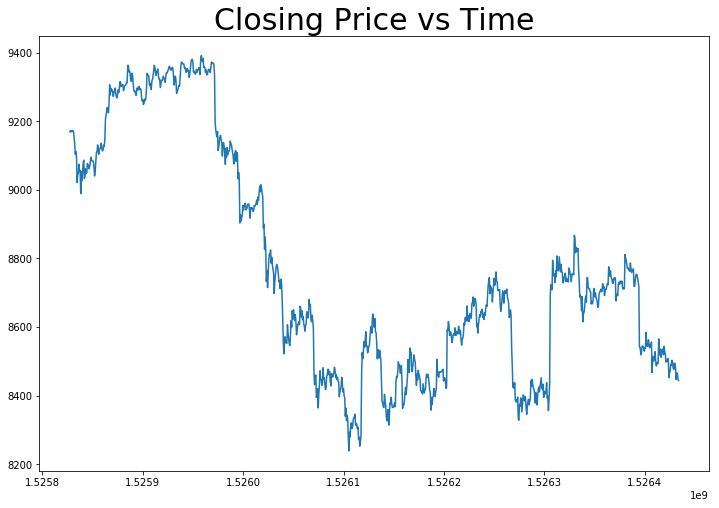

Transforming Data...


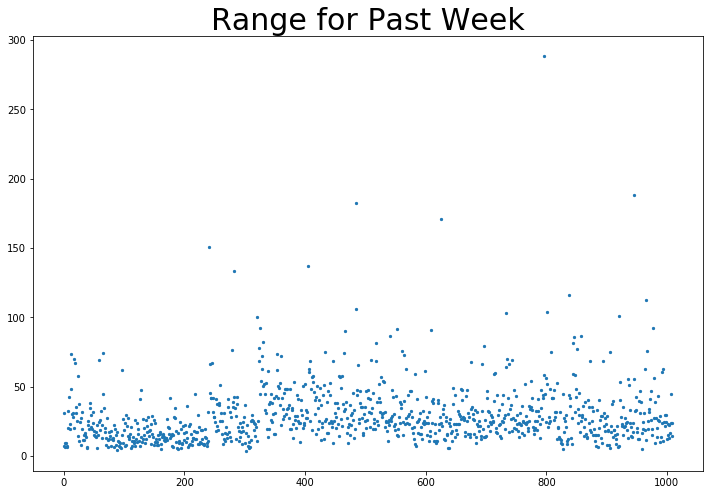

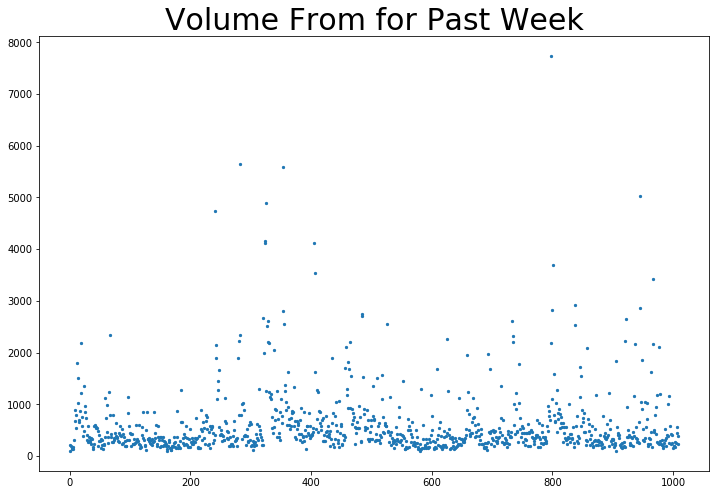

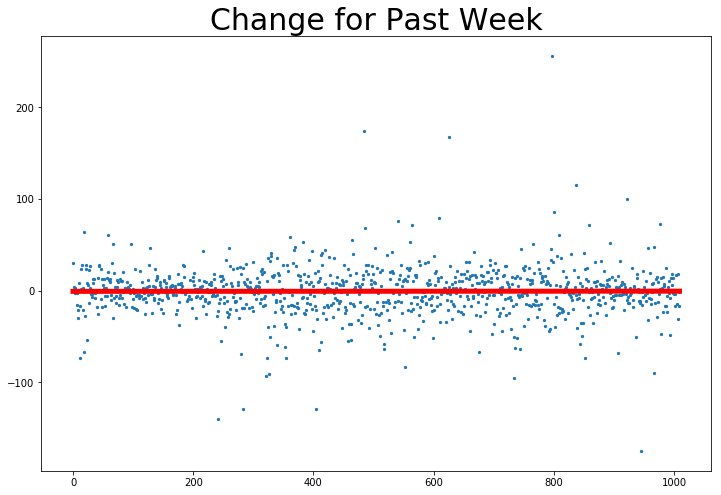

Creating and Saving Training and Testing Data...


In [ ]:
from tkinter import *

def run_model():
    do_it_all(model_type = e3.get(), symbol = e1.get(), aggregate= int(e2.get()))

window = Tk()
Label(window, text="Trading Symbol").grid(row=0)
Label(window, text="Aggregate Minutes").grid(row=1)
Label(window, text='SVM or Logistic?').grid(row=2)

e1 = Entry(window)
e2 = Entry(window)
e3 = Entry(window)

e1.grid(row=0, column=1)
e2.grid(row=1, column=1)
e3.grid(row=2, column=1)

Button(window, text='Run Model', command=run_model).grid(row=3, column=1, sticky=W, pady=4)

mainloop()